Heart Failures - ML in healthcare - NAM
===

Inspired from:
*  Colab: https://colab.research.google.com/drive/1E3_t7Inhol-qVPmFNq1Otj9sWt1vU_DQ?usp=sharing#scrollTo=ZobUtLyQ-M9r
*  Git repository: https://github.com/agarwl/google-research#egg=neural_additive_models&subdirectory=neural_additive_models
*  Graph builder: https://github.com/agarwl/google-research/blob/master/neural_additive_models/graph_builder.py
*  Models: https://github.com/agarwl/google-research/blob/master/neural_additive_models/models.py
*  Data Utils: https://github.com/agarwl/google-research/blob/master/neural_additive_models/data_utils.py
*  ExU in Pytorch: https://github.com/lemeln/nam/tree/main/nam/models/activation




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from scipy.stats import norm
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
import torch
import torch.nn.functional as F
from typing import Sequence
from typing import Tuple

In [3]:
# import sklearn as sk
# import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


# , precision_score, recall_score, auc, roc_curve, roc_auc_score, accuracy_score, classification_report 

In [4]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [5]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [6]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}',
 'Accuracy': '{:.1%}',
 'Balanced Accuracy': '{:.1%}',
 'F1 Score': '{:.1%}'}

# Local Parameters

In [7]:
class NotebookParams(param.Parameterized):
		lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
		n_nodes                  = param.Integer(default=20, bounds=(1,100),doc="Number of nodes in hidden layer")
		lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
		lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
		lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
		epochs                   = param.Integer(default=50 ,bounds=(20,2000))
		data_set                 = param.ObjectSelector(default="validation",objects=['train', 'validation', 'train + validation', 'test'])
		stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
		stand_embeddings         = param.Boolean(False, doc="Whether we want to standardize embeddings")
		use_lasso                = param.Boolean(False)
		use_focal_loss           = param.Boolean(True)
		use_exu	                 = param.Boolean(True)
		iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
		iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
		add_one_hot_encoded      = param.Boolean(True, doc="Whether to add one hot encoded columns from categorical variables")
		add_embeddings	         = param.Boolean(False, doc="Whether to add embeddings from categorical variables")
		max_emb_dim							 = param.Integer(50, bounds=(10,100),doc="Maximum embedding dimension")
		test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
		random_state_test_train_split = param.Integer(42)
# pn.Param(CustomExample.param, widgets={
#     'select_string': {'type': pn.widgets.RadioButtonGroup, 'button_type': 'primary'},
#     'select_number': pn.widgets.DiscretePlayer}
# )
base = NotebookParams()

# Import Data

In [8]:
df_heart = pd.read_csv('heart.csv')
# df_heart_test = pd.read_csv('ml4h_data/project1/heart_failure/test_split.csv')
# df_heart_train = pd.read_csv('ml4h_data/project1/heart_failure/train_val_split.csv')
df_heart_test = pd.read_csv('test_split.csv')
df_heart_train = pd.read_csv('train_val_split.csv')

In [9]:
df_heart.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1


In [10]:
df_heart_train.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


In [11]:
df_heart.describe().style.format(format_dict)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918,918,918,918.0,918,918.00,918.0
mean,54,132,199,0.2,137,0.89,0.6
std,9,19,109,0.4,25,1.07,0.5
min,28,0,0,0.0,60,-2.60,0.0
25%,47,120,173,0.0,120,0.00,0.0
50%,54,130,223,0.0,138,0.60,1.0
75%,60,140,267,0.0,156,1.50,1.0
max,77,200,603,1.0,202,6.20,1.0


# Features Preprocessing

In [16]:
num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']
# num_features = ['Cholesterol']
label_col = 'HeartDisease'
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
# Benchmark to be dropped for each categorical variable
category_to_drop = {}
# categorical_features = ['Sex']
for col in df_heart.columns:
    if col not in num_features + [label_col] + categorical_features:
        print(f'Column {col} is not in the list of features')

In [17]:
pn.Column(
    pn.Row(base.param.add_one_hot_encoded, base.param.stand_features, base.param.test_size, base.param.add_embeddings),
        )

BokehModel(combine_events=True, render_bundle={'docs_json': {'4b917bad-fd7b-4acd-9f98-9a08d393af3b': {'version…

In [18]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [19]:
train_test_data, final_categorical_features, all_features, embeddings_output = lib.pre_process_features(
        df_heart_train,
        num_features=num_features,
        categorical_features=categorical_features,
        category_to_drop=None,
        label_col=label_col,
        add_embeddings=base.add_embeddings,
        add_one_hot_encoded=base.add_one_hot_encoded,
        stand_features=base.stand_features,
        stand_embeddings=base.stand_embeddings,
				split_data=True,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
)
X_train, X_test = train_test_data.tensors['X_train'], train_test_data.tensors['X_test']
y_train, y_test = train_test_data.tensors['y_train'], train_test_data.tensors['y_test']
X_train_df = train_test_data.dataframes['X_train']
# all_features = list(X_train_df['all'].columns)

['M' 'F']
adding One Hot Encoded
['M' 'F']
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


## Working with the class imbalance

In [21]:
# From ... https://saturncloud.io/blog/how-to-use-class-weights-with-focal-loss-in-pytorch-for-imbalanced-multiclass-classification/#focal-loss
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total_samples = len(y_train)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights)

In [22]:
class_weights

[2.2150943396226412, 1.8229813664596275]

# Model Building

In [23]:
from torch.nn import Parameter

In [24]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        loss = (self.alpha[targets.long()] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss

In [25]:
class LinReLU(torch.nn.Module):
    __constants__ = ['bias']

    def __init__(
        self,
        in_features: int,
        out_features: int,
    ) -> None:
        super(LinReLU, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(in_features))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.trunc_normal_(self.bias, std=0.5)

    def forward(
        self,
        inputs: torch.Tensor,
    ) -> torch.Tensor:
        output = (inputs - self.bias) @ self.weight
        output = F.relu(output)

        return output

    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'


class ExU(torch.nn.Module):

	def __init__(
		self,
		in_features: int,
		out_features: int,
	) -> None:
				super(ExU, self).__init__()
				self.in_features = in_features
				self.out_features = out_features
				self.weight = Parameter(torch.Tensor(in_features, out_features))
				self.bias = Parameter(torch.Tensor(in_features))
				self.reset_parameters()

	def reset_parameters(self) -> None:
			## Page(4): initializing the weights using a normal distribution
			##          N(x; 0:5) with x 2 [3; 4] works well in practice.
			torch.nn.init.trunc_normal_(self.weight, mean=4.0, std=0.5)
			torch.nn.init.trunc_normal_(self.bias, std=0.5)

	def forward(
			self,
			inputs: torch.Tensor,
			n: int = 1,
	) -> torch.Tensor:
			output = (inputs - self.bias).matmul(torch.exp(self.weight))

			# ReLU activations capped at n (ReLU-n)
			output = F.relu(output)
			output = torch.clamp(output, 0, n)

			return output

	def extra_repr(self):
			return f'in_features={self.in_features}, out_features={self.out_features}'

In [26]:
class NumericalFeatureNN(torch.nn.Module):
	'''
		Neural Network for a single categorical feature.
	'''

	def __init__(
			self,
			feature_num: int,
			lin_layer_sizes: list,
			lin_layer_dropouts: list,
			activation = 'exu',
			):
		'''
		Parameters
		----------

		feature_num: Feature Index used for naming the hidden layers.
		
		lin_layer_sizes: List of integers.
			The size of each linear layer. The length will be equal
			to the total number
			of linear layers in the network.

		lin_layer_dropouts: List of floats
			The dropouts to be used after each linear layer.

		activation: Activation and type of hidden unit(ExUs/Standard) used in the 
			first hidden layer.
		'''
		super().__init__()

		self._feature_num = feature_num
		self._activation = activation
		self.lin_layer_sizes = lin_layer_sizes

		# Linear Layers
		# first_lin_layer = torch.nn.Linear(1, lin_layer_sizes[0]) # 1 as input size as we are building one NN by feature.

		## First layer is ExU
		if self._activation == "exu":
				first_lin_layer = (ExU(in_features=1, out_features=self.lin_layer_sizes[0]))
		else:
				first_lin_layer = LinReLU(in_features=1, out_features=self.lin_layer_sizes[0])


		self.lin_layers =\
			torch.nn.ModuleList([first_lin_layer] +\
					[torch.nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
						for i in range(len(lin_layer_sizes) - 1)])
    
		for lin_layer in self.lin_layers:
			torch.nn.init.kaiming_normal_(lin_layer.weight.data) # TODO(jpinole): check if necessary

		# Output Layer
		self.output_layer = torch.nn.Linear(lin_layer_sizes[-1], 1)
		torch.nn.init.kaiming_normal_(self.output_layer.weight.data)

		# Dropout Layers
		self.dropout_layers = torch.nn.ModuleList(
			[torch.nn.Dropout(size) for size in lin_layer_dropouts]
			)


	def forward(self, cont_data):

		x = cont_data

		for lin_layer, dropout_layer in\
				zip(self.lin_layers, self.dropout_layers):
			x = F.relu(lin_layer(x))
			x = dropout_layer(x)
		
		x = self.output_layer(x)

		return x


class NAM(torch.nn.Module):
	"""Neural additive model.

	Attributes:
		feature_nns: List of FeatureNN, one per input feature.
	"""
	def __init__(
			self,
			num_inputs: int,
			# num_units: list,
			# hidden_sizes: list,
			# dropout: float,
			feature_dropout: float,
			lin_layer_sizes: list,
			lin_layer_dropouts: list,
	) -> None:
		'''
		Parameters
		----------

		emb_dims: List of two element tuples
			This list will contain a two element tuple for each
			categorical feature. The first element of a tuple will
			denote the number of unique values of the categorical
			feature. The second element will denote the embedding
			dimension to be used for that feature.

		n_cont_features: Integer
			The number of continuous features in the data.

		lin_layer_sizes: List of integers.
			The size of each linear layer. The length will be equal
			to the total number
			of linear layers in the network.

		output_size: Integer
			The size of the final output.

		emb_dropout: Float
			The dropout to be used after the embedding layers.

		lin_layer_dropouts: List of floats
			The dropouts to be used after each linear layer.
			'''

		''' 
		COMMENT. In the original implementation, if there is more than one hidden layer,
		authors use an exU activation function instead of ReLu for the first hidden layer.
		I will skip this implementation for now.
		TODO(juliepinole): implement the exU activation to see if results/ optimization improve.
		'''

		super(NAM, self).__init__()
		self.num_inputs = num_inputs
		# self.num_units = num_units
		# self.hidden_sizes = hidden_sizes
		# self.dropout = dropout
		self.feature_dropout = feature_dropout
		self.lin_layer_sizes = lin_layer_sizes
		self.lin_layer_dropouts = lin_layer_dropouts

		self.dropout_layer = torch.nn.Dropout(p=self.feature_dropout)

		# Output Layer
		self.output_layer = torch.nn.Linear(self.num_inputs, 1)

		# Sigmoid Activation
		self.sigmoid = torch.nn.Sigmoid()

		## Builds the FeatureNNs on the first call.
		self.feature_nns = torch.nn.ModuleList([
				NumericalFeatureNN(
						lin_layer_sizes = self.lin_layer_sizes, 
						lin_layer_dropouts=self.lin_layer_dropouts,
						feature_num=i,
				)
				for i in range(num_inputs)
		])

		self._bias = torch.nn.Parameter(data=torch.zeros(1))


	def calc_outputs(self, inputs: torch.Tensor) -> Sequence[torch.Tensor]:
			"""Returns the output computed by each feature net."""
			n_examples = inputs.shape[0]
			return [self.feature_nns[i](inputs[:, i].view(n_examples, 1)) for i in range(self.num_inputs)]

			# x_train = x_train.view(101, 1)

	def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
			individual_outputs = self.calc_outputs(inputs)
			conc_out = torch.cat(individual_outputs, dim=-1)
			dropout_out = self.dropout_layer(conc_out)
			# out = torch.sum(dropout_out, dim=-1)
			# print(f'lin_layer shape is {lin_layer.weight.shape}')
			# print(f'lin_layer weights are {lin_layer.weight}')	
			out = self.sigmoid(self.output_layer(dropout_out) + self._bias)
			return out, dropout_out
			# return out + self._bias, dropout_out

# Training

In [27]:
pn.Column(
    pn.Row(base.param.use_exu, base.param.use_focal_loss),
    pn.Row(base.param.lr_power, base.param.lr_multiple),
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'ad4ec30c-e623-46c0-8ce7-4580cc5d863b': {'version…

In [28]:
lr = base.lr_multiple * 10**(-base.lr_power)
print('learning rate is {} multiplied by 10 power {}, which yields {:.8f}'.format(base.lr_multiple, -base.lr_power, lr))
lambda_lasso = base.lambda_multiple * 10**(-base.lambda_power)
print('lambda_lasso is {} multiplied by 10 power {}, which yields {:.6f}'.format(base.lambda_multiple, -base.lambda_power, lambda_lasso))

learning rate is 5 multiplied by 10 power -3, which yields 0.00500000
lambda_lasso is 1 multiplied by 10 power -2, which yields 0.010000


In [30]:
pn.Column(
    pn.Row(base.param.epochs, base.param.iter_array, base.param.iter_printing),
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'d32df8dd-6e99-4f71-b4c3-b30e96140cfc': {'version…

In [31]:
num_inputs = len(num_features + final_categorical_features)
output_dim = 1 # Single binary output
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NAM(
        num_inputs=num_inputs,
				feature_dropout=0.01,
				lin_layer_sizes=[50,80],
				lin_layer_dropouts=[0.001, 0.01],
).to(device)
if base.use_focal_loss:
    criterion = FocalLoss(alpha=class_weights_tensor.long(), gamma=2)
else:
    criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
iter_printing_effective = int(base.epochs/base.iter_printing)
print('iter_printing_effective is {}'.format(iter_printing_effective))
# torch.manual_seed(0) # keep things reproducible

/home/pinolej/.venv/lib/python3.10/site-packages/torch/nn/init.py:205: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b, generator=generator)


iter_printing_effective is 126


In [32]:
losses = []
losses_test = []
Iterations = []
iter = 0
model.train()
for epoch in tqdm(range(int(base.epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs, fnn_out = model(X_train['all'])  # Perform forward pass
    loss = criterion(torch.squeeze(outputs), labels) # Compute loss
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

    # Compute L1 loss component
    # if base.use_lasso:
    #     loss = add_l1_loss(model, loss, lambda_lasso=lambda_lasso)

    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%base.iter_array==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test, fnn_out_test = model(X_test['all'])
            loss_test = criterion(torch.squeeze(outputs_test), y_test)
            # loss_test = add_l1_loss(model, loss_test, lambda_lasso=lambda_lasso)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)

            if iter%iter_printing_effective==0:
                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs: 100%|█████████▉| 631/634 [00:58<00:00, 17.75it/s]

Iteration: 630. 
Test - Loss: 0.13010135293006897. Accuracy: 7307.482993197279
Train -  Loss: 0.13495388627052307. Accuracy: 81.94207836456559



Training Epochs: 100%|██████████| 634/634 [00:59<00:00, 10.73it/s]


Text(0, 0.5, 'Focal Loss')

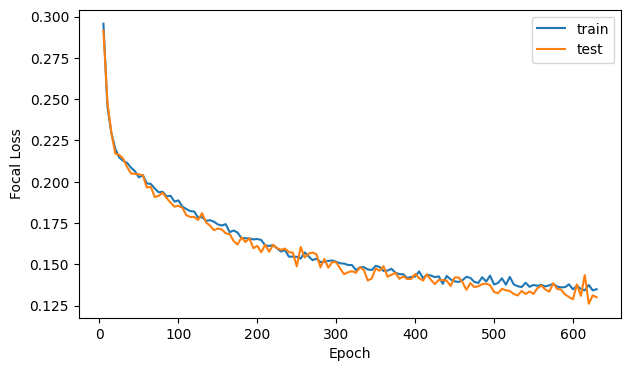

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
ax.plot(Iterations,losses, label='train')
ax.plot(Iterations,losses_test, label='test')
ax.legend()
ax.set_xlabel('Epoch')
loss_type = 'Focal Loss' if base.use_focal_loss else 'BCE Loss'
ax.set_ylabel(loss_type)
# fig.show()

# Evaluation

## Predictions performances

### Predicting

In [35]:
pn.Row(base.param.data_set)

BokehModel(combine_events=True, render_bundle={'docs_json': {'027c3dc2-39d5-4912-9f26-552fdf640a37': {'version…

In [36]:
dataset_choice = {
    'train': {
        'data': {
            'x': train_test_data.tensors['X_train']['all'],
            'y': train_test_data.tensors['y_train'],
        },
        'already_processed': True,
    },
    'validation': {
        'data': {
            'x': train_test_data.tensors['X_test']['all'],
            'y': train_test_data.tensors['y_test'],
        },
        'already_processed': True,
    },
    'train + validation': {
        'data': df_heart_train,
        'already_processed': False,
    },
    'test': {
        'data': df_heart_test,
        'already_processed': False,
    },
    'all': {
        'data': df_heart,
        'already_processed': False,
    },
}
print('We are displaying evaluation over the {} dataset'.format(base.data_set.upper()))
data_specs = dataset_choice[base.data_set]

We are displaying evaluation over the TEST dataset


In [37]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [38]:
if data_specs['already_processed']:
    print('Data were already processed for training.')
    x_features = data_specs['data']['x'] # A dictionary
    y_true = data_specs['data']['y']
else:
        print('Processing data')
        processed_data, _, _, _ = lib.pre_process_features(
                data_specs['data'],
                num_features=num_features,
                categorical_features=categorical_features,
                category_to_drop=None,
                label_col=label_col,
                add_one_hot_encoded=base.add_one_hot_encoded,
                add_embeddings=base.add_embeddings,
                stand_features=base.stand_features,
        				stand_embeddings=base.stand_embeddings,
                test_size=base.test_size,
                random_state=base.random_state_test_train_split,
                split_data=False,
        )
        x_features = processed_data.tensors['X_train'] # Now importing a dictionary
        y_true = processed_data.tensors['y_train']
        x_features_df = processed_data.dataframes['X_train']

Processing data
['M' 'F']
adding One Hot Encoded
['M' 'F']
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


In [39]:
list(x_features_df['all'].columns)

['Age',
 'RestingBP',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'FastingBS',
 'Sex_F',
 'Sex_M',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'RestingECG_LVH',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up']

In [40]:
model.eval()
outputs, fnn_out = model(x_features['all'])
y_pred_tensor = torch.squeeze(outputs)
y_pred_round_tensor = y_pred_tensor.round()
y_pred = y_pred_tensor.detach().numpy()
y_pred_round = y_pred_round_tensor.detach().numpy()

### NAM Visualization

In [83]:
FEATURE_LABEL_MAPPING = {
    'Age': (None, 45),
}
FEATURE_LABEL_MAPPING['Recidivism'] = {
    'race': (['African\nAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other'], 90),
    'sex': (['Female', 'Male'], None)
}

FEATURE_LABEL_MAPPING['Mimic2'] = {
    'AIDS': (['No', 'Yes'], None),
    'Lymphoma': (['No', 'Yes'], None),
    'MetastaticCancer': (['No', 'Yes'], None),
}
FEATURE_LABEL_MAPPING['Fico'] = {}

In [80]:
COL_NAMES = {
    'Age': 'Age',
    'RestingBP': 'Resting Blood Pressure',
    'Cholesterol': 'Cholesterol',
    'MaxHR': 'Max Heart Rate',
    'Oldpeak': 'Oldpeak',
    'FastingBS': 'Fasting Blood Sugar',
    'Sex_F': 'Sex_F',
    'Sex_M': 'Sex_M',
		'ChestPainType_ASY': 'ChestPainType_ASY',
		'ChestPainType_ATA': 'ChestPainType_ATA',
		'ChestPainType_NAP': 'ChestPainType_NAP',
		'ChestPainType_TA': 'ChestPainType_TA',
		'RestingECG_LVH': 'RestingECG_LVH',
		'RestingECG_Normal': 'RestingECG_Normal',
		'RestingECG_ST': 'RestingECG_ST',
		'ExerciseAngina_N': 'ExerciseAngina_N',
		'ExerciseAngina_Y': 'ExerciseAngina_Y',
		'ST_Slope_Down': 'ST_Slope_Down',
		'ST_Slope_Flat': 'ST_Slope_Flat',
		'ST_Slope_Up': 'ST_Slope_Up',
}
CATEGORICAL_NAMES = categorical_features

In [49]:
#@title Helper functions for NAM visualization
def compute_features(x_data):
  single_features = np.split(x_data, x_data.shape[1], axis=1)
  unique_features = [np.unique(f, axis=0) for f in single_features]
  return unique_features


def get_feature_predictions(nn_model, x_data):
	feature_predictions = []
	model.eval()
	unique_features = compute_features(x_data)
	for c, i in enumerate(unique_features):
		f_preds = nn_model.feature_nns[c](torch.from_numpy(i))
		feature_predictions.append(f_preds)    
	return feature_predictions

In [50]:
unique_features = compute_features(x_features['all'])
feature_predictions = get_feature_predictions(model, x_features['all'])

In [51]:
#@title Dataset helpers

def compute_col_min_max(x_data):
  col_min_max = {}
  for col in x_data:
    unique_vals = x_data[col].unique()
    col_min_max[col] = (np.min(unique_vals), np.max(unique_vals))
  return col_min_max

def inverse_min_max_scaler(x, min_val, max_val):
  return (x + 1)/2 * (max_val - min_val) + min_val 

In [52]:
#@title Individual arrays for each Dataset feature

NUM_FEATURES = x_features['all'].shape[1]
SINGLE_FEATURES = np.split(x_features['all'], NUM_FEATURES, axis=1)
UNIQUE_FEATURES = [np.unique(x, axis=0) for x in SINGLE_FEATURES]

SINGLE_FEATURES_ORIGINAL = {}
UNIQUE_FEATURES_ORIGINAL = {}

col_min_max = compute_col_min_max(x_features_df['all'])

for i, col in enumerate(all_features):
  min_val, max_val = col_min_max[col]
  UNIQUE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(
      UNIQUE_FEATURES[i][:, 0], min_val, max_val)
  SINGLE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(
      SINGLE_FEATURES[i][:, 0], min_val, max_val)

In [62]:
avg_hist_data = {col: predictions.detach().numpy() for col, predictions in zip(all_features, feature_predictions)}

In [63]:
#@title Calculate the mean prediction

ALL_INDICES = {}
MEAN_PRED = {}

for i, col in enumerate(all_features):
  x_i = x_features['all'][:, i]
  ALL_INDICES[col] = np.searchsorted(UNIQUE_FEATURES[i][:, 0], x_i, 'left')
for col in all_features:
  MEAN_PRED[col] =  np.mean([avg_hist_data[col][i] for i in ALL_INDICES[col]])

print(MEAN_PRED)

{'Age': -0.5734854, 'RestingBP': 0.39035553, 'Cholesterol': -1.923889, 'MaxHR': 1.1495063, 'Oldpeak': 0.77453464, 'FastingBS': -0.16865972, 'Sex_F': 0.37430108, 'Sex_M': 0.57240343, 'ChestPainType_ASY': -0.045719177, 'ChestPainType_ATA': 0.24365744, 'ChestPainType_NAP': 0.35900107, 'ChestPainType_TA': -0.6399933, 'RestingECG_LVH': -0.187643, 'RestingECG_Normal': 2.3476222, 'RestingECG_ST': 0.06342484, 'ExerciseAngina_N': 1.1749128, 'ExerciseAngina_Y': 0.5281806, 'ST_Slope_Down': 0.55706286, 'ST_Slope_Flat': 1.7548709, 'ST_Slope_Up': -1.038276}


In [72]:
#@title Helpers for MEAN feature importance

def compute_mean_feature_importance(avg_hist_data):
  mean_abs_score = {}
  for k in avg_hist_data:
    mean_abs_score[k] = np.mean(np.abs(avg_hist_data[k] - MEAN_PRED[k]))
  x1, x2 = zip(*mean_abs_score.items())
  return x1, x2

def plot_mean_feature_importance(x1, x2, width = 0.3):
  fig = plt.figure(figsize=(5, 4))
  ind = np.arange(len(x1))  # the x locations for the groups
  x1_indices = np.argsort(x2)
  cols_here = [cols[i] for i in x1_indices]
  # x1_here = [x12[i] for i in x1_indices]
  x2_here = [x2[i] for i in x1_indices]

  plt.bar(ind, x2_here, width, label='NAMs')
  # plt.bar(ind+width, x1_here, width, label='EBMs')
  plt.xticks(ind + width/2, cols_here, rotation=90, fontsize='large')
  plt.ylabel('Mean Absolute Score', fontsize='x-large')
  plt.legend(loc='upper right', fontsize='large')
  plt.title(f'Overall Importance: Heart Disease', fontsize='x-large')
  plt.show()
  return fig

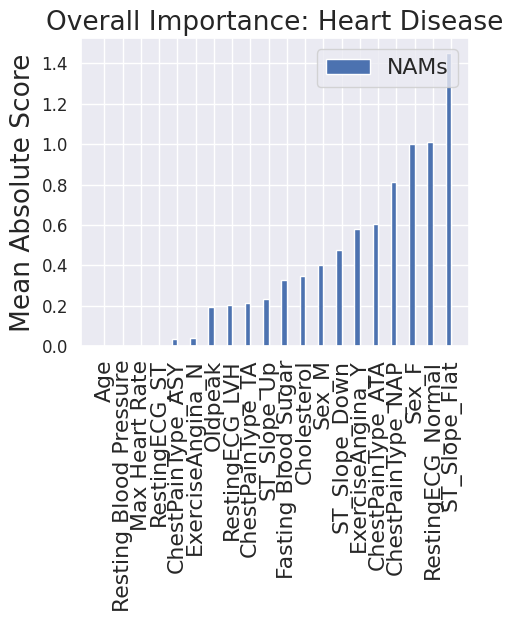

In [74]:
#@title Global feature importance

x1, x2 = compute_mean_feature_importance(avg_hist_data)
cols = [COL_NAMES[x] for x in x1]
fig = plot_mean_feature_importance(x1, x2)

In [93]:
#@title Plotting Helper Functions

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches

def shade_by_density_blocks(hist_data, num_rows, num_cols, 
														n_blocks=5, color=[0.9, 0.5, 0.5], 
														feature_to_use=None):
	hist_data_pairs = list(hist_data.items())
	hist_data_pairs.sort(key=lambda x: x[0])
	min_y = np.min([np.min(a[1]) for a in hist_data_pairs])
	max_y = np.max([np.max(a[1]) for a in hist_data_pairs])
	min_max_dif = max_y - min_y
	min_y = min_y - 0.01 * min_max_dif
	max_y = max_y + 0.01 * min_max_dif

	if feature_to_use:
		hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use] 

	for i, (name, pred) in enumerate(hist_data_pairs):

		# unique_x_data, single_feature_data, pred = data
		unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
		single_feature_data = SINGLE_FEATURES_ORIGINAL[name]
		ax = plt.subplot(num_rows, num_cols, i+1)
		min_x = np.min(unique_x_data)
		max_x = np.max(unique_x_data)
		x_n_blocks = min(n_blocks, len(unique_x_data))
		if name in CATEGORICAL_NAMES:
			min_x -= 0.5
			max_x += 0.5
		segments = (max_x - min_x) / x_n_blocks
		density = np.histogram(single_feature_data, bins=x_n_blocks)
		normed_density = density[0] / np.max(density[0])
		rect_params = []
		for p in range(x_n_blocks):
			start_x = min_x + segments * p
			end_x = min_x + segments * (p + 1)
			# start_insert_index = min(
			#     max(0, np.searchsorted(density[1], start_x) - 1), x_n_blocks - 1)
			# end_insert_index = min(
			#     max(0, np.searchsorted(density[1], end_x) - 1), x_n_blocks - 1)
			# d = (normed_density[start_insert_index] + normed_density[end_insert_index])/2
			d = min(1.0, 0.01 + normed_density[p])
			rect_params.append((d, start_x, end_x))

		for param in rect_params:
			alpha, start_x, end_x = param 
			rect = patches.Rectangle((start_x, min_y - 1), end_x - start_x, 
																max_y - min_y + 1, linewidth=0.01, 
															edgecolor=color, facecolor=color, alpha=alpha)
			ax.add_patch(rect)


def plot_all_hist(hist_data, num_rows, num_cols,  color_base, 
									linewidth=3.0, min_y=None, max_y=None, alpha=1.0, 
									feature_to_use=None):
	hist_data_pairs = list(hist_data.items())
	hist_data_pairs.sort(key=lambda x: x[0])
	if min_y is None:
		min_y = np.min([np.min(a) for _, a in hist_data_pairs])
	if max_y is None:
		max_y = np.max([np.max(a) for _, a in hist_data_pairs])
	min_max_dif = max_y - min_y
	min_y = min_y - 0.01 * min_max_dif
	max_y = max_y + 0.01 * min_max_dif
	col_mapping = COL_NAMES
	feature_mapping = FEATURE_LABEL_MAPPING

	total_mean_bias = 0

	if feature_to_use:
		hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use] 

	for i, (name, pred) in enumerate(hist_data_pairs):
		mean_pred = MEAN_PRED[name] #np.mean(pred)
		total_mean_bias += mean_pred
		unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
		plt.subplot(num_rows, num_cols, i+1)

		if name in CATEGORICAL_NAMES:
			unique_x_data = np.round(unique_x_data, decimals=1)
			if len(unique_x_data) <= 2:
				step_loc = "mid"
			else:
				step_loc = "post"
			unique_plot_data = np.array(unique_x_data) - 0.5
			unique_plot_data[-1] += 1
			plt.step(unique_plot_data, pred - mean_pred, color=color_base, 
								linewidth=linewidth, where=step_loc, alpha=alpha)

			if name in feature_mapping:
				labels, rot = feature_mapping[name]
			else:
				labels = unique_x_data
				rot = None
			plt.xticks(unique_x_data, labels=labels, fontsize='medium', rotation=rot)
		else:
			plt.plot(unique_x_data, pred - mean_pred, color=color_base, 
								linewidth=linewidth, alpha=alpha)
			if name in feature_mapping:
				_, rot = feature_mapping[name]
			else:
				rot = None
			plt.xticks(fontsize='medium', rotation=rot)

		
		plt.ylim(min_y, max_y)
		plt.yticks(fontsize='x-large')
		min_x = np.min(unique_x_data)
		max_x = np.max(unique_x_data)
		if name in CATEGORICAL_NAMES:
			min_x -= 0.5
			max_x += 0.5
		plt.xlim(min_x, max_x)
		if i % num_cols == 0:
			plt.ylabel('Heart Disease Contribution', fontsize='large')
		plt.xlabel(col_mapping[name], fontsize='medium')
	return min_y, max_y

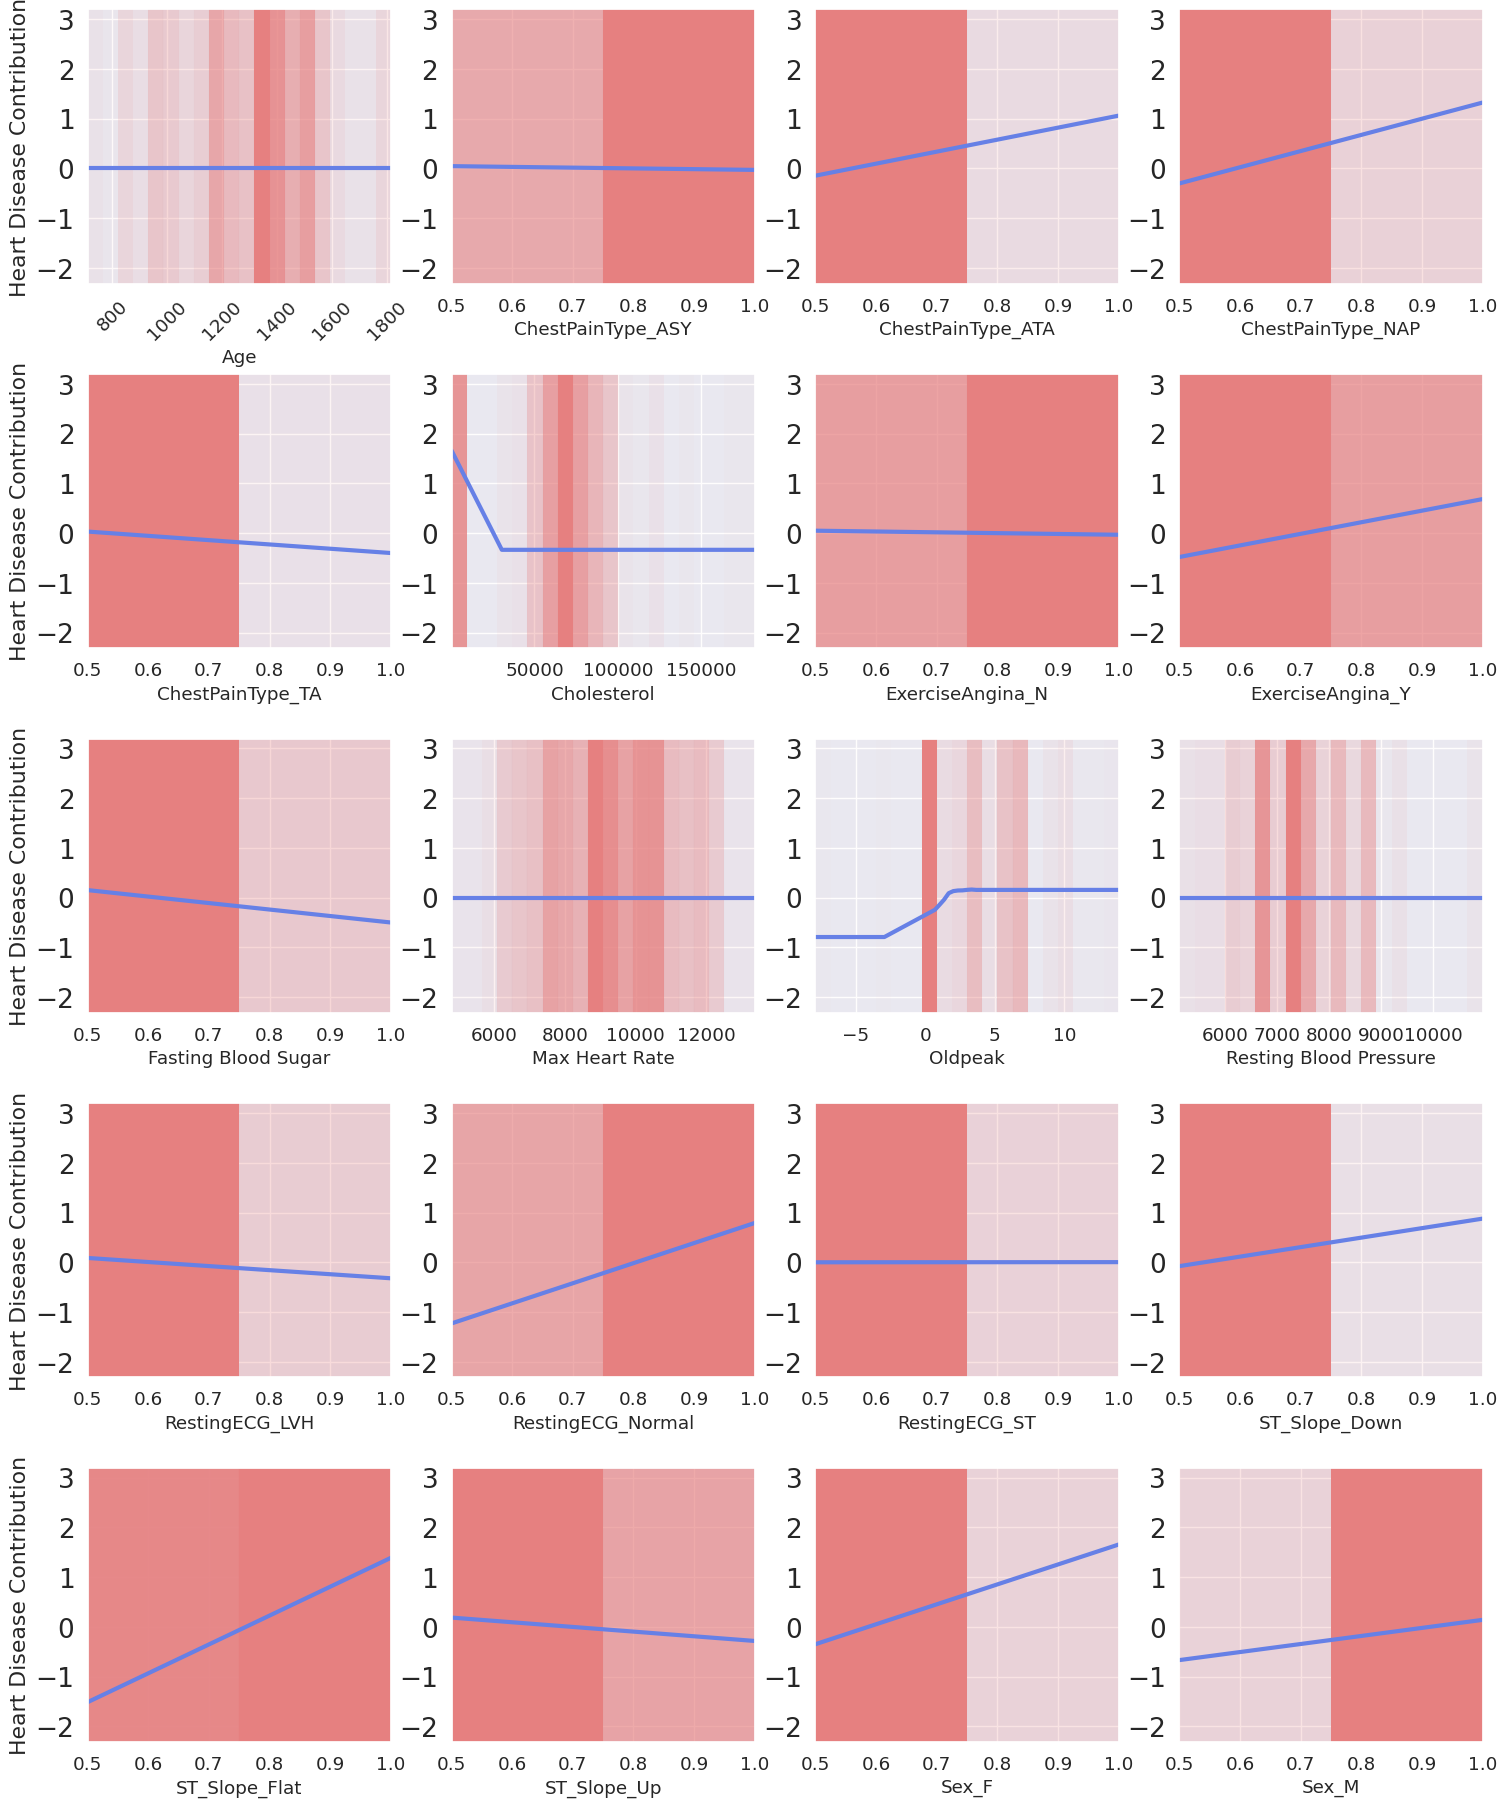

In [94]:
COLORS = [[0.9, 0.4, 0.5], [0.5, 0.9, 0.4], [0.4, 0.5, 0.9], [0.9, 0.5, 0.9]]
NUM_COLS =  4#@param {'type': 'integer'}
N_BLOCKS =  20#@param 

MIN_Y = None
MAX_Y = None


NUM_ROWS = int(np.ceil(NUM_FEATURES / NUM_COLS))
fig = plt.figure(num=None, figsize=(NUM_COLS * 4.5, NUM_ROWS * 4.5),
                 facecolor='w', edgecolor='k')

MIN_Y, MAX_Y = plot_all_hist(avg_hist_data, NUM_ROWS, NUM_COLS, COLORS[2],
                             min_y=MIN_Y, max_y=MAX_Y, feature_to_use=all_features)
shade_by_density_blocks(avg_hist_data, NUM_ROWS, NUM_COLS, n_blocks=N_BLOCKS, feature_to_use=all_features)

# This is for plotting individual plots when there are multiple models
"""
for pred in feature_predictions:
  model_hist = {col: pred[0, i] for i, col in enumerate(column_names)}
  plot_all_hist(model_hist, NUM_ROWS, NUM_COLS,
                color_base=[0.3, 0.4, 0.9, 0.2], alpha=0.06,
                linewidth=0.1, min_y=MIN_Y, max_y=MAX_Y, feature_to_use=features)
"""
plt.subplots_adjust(hspace=0.33)
plt.show()

### Classic Performance Metrics

In [41]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [42]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,77.7%,77.8%,80.6%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

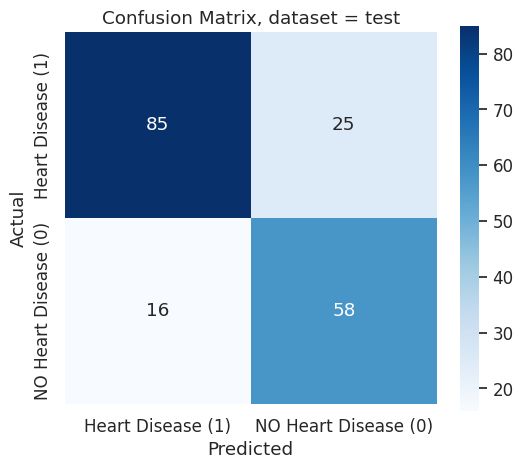

In [43]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [44]:
logreg_conf_matrix

array([[58, 16],
       [25, 85]])

In [45]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

/home/pinolej/eth/healthcare/heart/graph.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/heart/graph.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


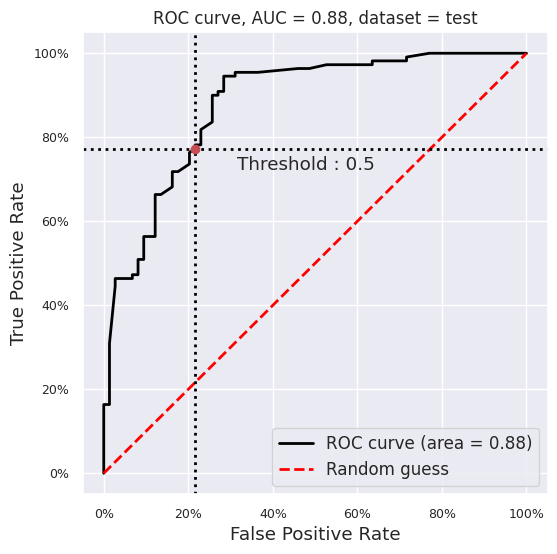

In [46]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

# Appendix

In [43]:
model_2 = torch.nn.Sequential(
    torch.nn.Linear(3, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 1),
)

print(model_2(torch.randn(4, 3))) # feed it 4 random 3-dim. vectors

tensor([[0.3709],
        [0.4930],
        [0.4063],
        [0.3934]], grad_fn=<AddmmBackward0>)


In [ ]:
# class Example(BaseClass):
#     """An example Parameterized class"""
#     timestamps = []

#     boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
#     color                   = param.Color(default='#FFFFFF')
#     date                    = param.Date(dt.datetime(2017, 1, 1),
#                                          bounds=(dt.datetime(2017, 1, 1), dt.datetime(2017, 2, 1)))
#     select_string           = param.ObjectSelector(default="yellow",objects=["red","yellow","green"])
#     select_fn               = param.ObjectSelector(default=list,objects=[list,set,dict])
#     int_list                = param.ListSelector(default=[3,5], objects=[1,3,5,7,9],precedence=0.5)
#     single_file             = param.FileSelector(path='../../*/*.py*',precedence=0.5)
#     multiple_files          = param.MultiFileSelector(path='../../*/*.py?',precedence=0.5)
#     record_timestamp        = param.Action(lambda x: x.timestamps.append(dt.datetime.now()),
#                                            doc="""Record timestamp.""",precedence=0.7)

In [ ]:
#   def exu(x, weight, bias):
#   """ExU hidden unit modification."""
#   return torch.exp(weight) * (x - bias)


# # Activation Functions
# def relu(x, weight, bias):
#   """ReLU activation."""
#   return F.relu(weight * (x - bias))


# def relu_n(x, n = 1):
#   """ReLU activation clipped at n."""
# 	return torch.clamp(x, min=0, max=n)


# class ActivationLayer(torch.nn.Module):
#   """Custom activation Layer to support ExU hidden units."""

#   def __init__(self,
#                num_units,
#                name = None,
#                activation = 'exu',
#                trainable = True):
#     """Initializes ActivationLayer hyperparameters.

#     Args:
#       num_units: Number of hidden units in the layer.
#       name: The name of the layer.
#       activation: Activation to use. The default value of `None` corresponds to
#         using the ReLU-1 activation with ExU units while `relu` would use
#         standard hidden units with ReLU activation.
#       trainable: Whether the layer parameters are trainable or not.
#     """
#     super(ActivationLayer, self).__init__(trainable=trainable, name=name)
#     self.num_units = num_units
#     self._trainable = trainable
#     if activation == 'relu':
#       self._activation = relu
#       self._beta_initializer = 'glorot_uniform'
#     elif activation == 'exu':
#       self._activation = lambda x, weight, bias: relu_n(exu(x, weight, bias))
#       self._beta_initializer = torch.nn.init.trunc_normal_(self, mean=4.0, stddev=0.5)
#     else:
#       raise ValueError('{} is not a valid activation'.format(activation))

#   	# def build(self, input_shape):
#     """Builds the layer weight and bias parameters."""
# 		self._beta = torch.nn.Parameter(data=torch.Tensor(1, 1, 1, 1), requires_grad=True)
# 		self._beta = self.add_weight(
#         name='beta',
#         shape=[input_shape[-1], self.num_units],
#         initializer=self._beta_initializer,
#         trainable=self._trainable)
#     self._c = self.add_weight(
#         name='c',
#         shape=[1, self.num_units],
#         initializer=tf.initializers.truncated_normal(stddev=0.5),
#         trainable=self._trainable)
#     super(ActivationLayer, self).build(input_shape)


#   def call(self, x):
#     """Computes the output activations."""
#     center = tf.tile(self._c, [tf.shape(x)[0], 1])
#     out = self._activation(x, self._beta, center)
#     return out

# 	def forward(self, x):
# 		outputs = torch.sigmoid(self.linear(x))
# 		return outputs

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        print('be loss is {}'.format(be_loss))
        print('pt is {}'.format(pt))
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss

In [ ]:
# From https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/

class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x


class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
class CategoricalFeatureNN(torch.nn.Module):
	'''
		Neural Network for a single categorical feature.
	'''

	def __init__(self, emb_dims, n_cont_features, lin_layer_sizes,
			  output_size, emb_dropout, lin_layer_dropouts, activation = 'exu'):
		'''
		Parameters
		----------

		emb_dims: List of two element tuples
			This list will contain a two element tuple for each
			categorical feature. The first element of a tuple will
			denote the number of unique values of the categorical
			feature. The second element will denote the embedding
			dimension to be used for that feature.

		lin_layer_sizes: List of integers.
			The size of each linear layer. The length will be equal
			to the total number
			of linear layers in the network.

		output_size: Integer
			The size of the final output.

		emb_dropout: Float
			The dropout to be used after the embedding layers.

		lin_layer_dropouts: List of floats
			The dropouts to be used after each linear layer.

		activation: Activation and type of hidden unit(ExUs/Standard) used in the 
			first hidden layer.
		'''
		super().__init__()
    # Embedding layers
		self.emb_layer = torch.nn.Embedding(emb_dims[0], emb_dims[1])

		self.n_embs = emb_dims[1]

		# Linear Layers
		first_lin_layer = torch.nn.Linear(self.n_embs, lin_layer_sizes[0])

		self.lin_layers =\
			torch.nn.ModuleList([first_lin_layer] +\
					[torch.nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
						for i in range(len(lin_layer_sizes) - 1)])
    
		for lin_layer in self.lin_layers:
			torch.nn.init.kaiming_normal_(lin_layer.weight.data) # TODO(jpinole): check if necessary

		# Output Layer
		self.output_layer = torch.nn.Linear(lin_layer_sizes[-1], output_size)
		torch.nn.init.kaiming_normal_(self.output_layer.weight.data)

		# Dropout Layers
		self.emb_dropout_layer = torch.nn.Dropout(emb_dropout)
		self.dropout_layers = torch.nn.ModuleList([torch.nn.Dropout(size)
																	for size in lin_layer_dropouts])

	def forward(self, cat_data):

		x = self.emb_layer(cat_data)
		x = self.emb_dropout_layer(x)

		for lin_layer, dropout_layer in\
				zip(self.lin_layers, self.dropout_layers):
			x = F.relu(lin_layer(x))
			x = dropout_layer(x)
		
		x = self.output_layer(x)

		return x